## EfnBoost for Survival Analysis

### Introduction
EfnBoost is a method of survival analysis that predicts hazard ratio of coxph using `xgboost` by optimizing the loss function of *Efron Approximation*.

Here we show you how to use EfnBoost model to predict hazard ratio from scratch with the help of `libsurv`.

### Preparation

For all things going well, you would be better to get acquainted with **Survival Analysis**. Otherwise, I suggest you read the [reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html).

And it may help a lot if you know a little of the Efron Approximation.

### Get it started

#### Load datasets

We provide `WHAS` and `METABRIC` datasets for further studies. It can be found in module `libsurv.datasets`.

In [1]:
from libsurv.datasets import load_whas_train
from libsurv.datasets import load_whas_test

data_train = load_whas_train()
data_test = load_whas_test()

In [2]:
print(data_train.columns)

Index(['age', 'gender', 'bmi', 'chf', 'miord', 'e', 't'], dtype='object')


#### Statistics of datasets
Print statistics of survival data. The function `survival_stats` in `libsurv.datasets` provides the tool.

--------------- Survival Data Statistics ---------------
# Rows: 1310
# Columns: 5 + e + t
# Events Ratio: 42.14%
# Min Time: 1
# Max Time: 67



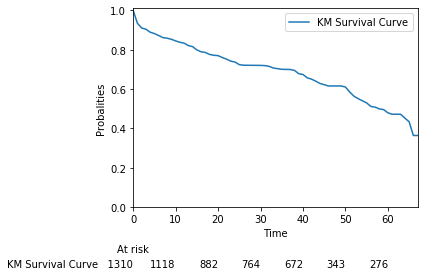

In [3]:
from libsurv.datasets import survival_stats

survival_stats(data_train, t_col="t", e_col="e", plot=True)

--------------- Survival Data Statistics ---------------
# Rows: 328
# Columns: 5 + e + t
# Events Ratio: 42.07%
# Min Time: 1
# Max Time: 67



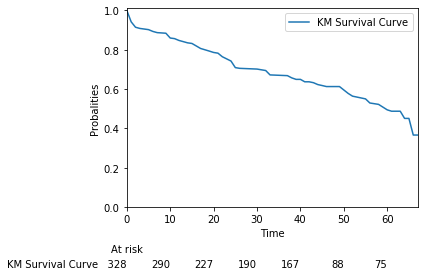

In [4]:
survival_stats(data_test, t_col="t", e_col="e", plot=True)

#### Survival data transfrom

The column of time and status in survival data will be packed into an new column as label in the transformed data.

The transformed survival data contains an new label, where negtive values are considered as right censored, and positive values are considered as event occurrence.

**NOTE**: In `libsurv`, survival data must be transformed via `libsurv.datasets.survival_df`. But for `xgboost` model, the type of data must be `DMatrix`, so we **have two ways to achive this as listed below**.

```python
##############################################################################
# method 1:
from libsurv.datasets import survival_dmat

surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

##############################################################################

##############################################################################
# method 2
from libsurv.datasets import survival_df
from xgboost import DMatrix


data_train = survival_df(data_train, t_col="t", e_col="e", label_col="Y")
data_test = survival_df(data_test, t_col="t", e_col="e", label_col="Y")

x_cols = list(data_train.columns)[:-1]

surv_train = DMatrix(data_train[x_cols], label=data_train['Y'].values)
surv_test = DMatrix(data_test[x_cols], label=data_test['Y'].values)
################################################################################
```

In [5]:
from libsurv.datasets import survival_dmat

# via survival_dmat function
surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

#### Model initialization

Here we start to initialize a EfnBoost model.

In [6]:
from libsurv import EfnBoost

params = {
    'eta':0.3,
    'max_depth':6, 
    'min_child_weight': 8, 
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'gamma': 0.20,
    'lambda': 0,
}

model = EfnBoost(params)

#### Model training

Training model and plotting the learning curve.

[0]	train-rmse:41.3217	test-rmse:41.5243	train-efron_loss:6.33549	test-efron_loss:5.01289
[10]	train-rmse:40.8059	test-rmse:40.9993	train-efron_loss:5.82957	test-efron_loss:4.58238
[20]	train-rmse:40.5256	test-rmse:40.7227	train-efron_loss:5.62913	test-efron_loss:4.47407
[30]	train-rmse:40.4061	test-rmse:40.5946	train-efron_loss:5.55106	test-efron_loss:4.43801
[40]	train-rmse:40.3299	test-rmse:40.5241	train-efron_loss:5.488	test-efron_loss:4.41013
[50]	train-rmse:40.2506	test-rmse:40.445	train-efron_loss:5.4044	test-efron_loss:4.3916
[60]	train-rmse:40.1344	test-rmse:40.3247	train-efron_loss:5.32814	test-efron_loss:4.34763
[70]	train-rmse:40.0715	test-rmse:40.2611	train-efron_loss:5.26257	test-efron_loss:4.31722
[80]	train-rmse:40.0233	test-rmse:40.2129	train-efron_loss:5.21244	test-efron_loss:4.29579
[90]	train-rmse:39.9559	test-rmse:40.1542	train-efron_loss:5.18857	test-efron_loss:4.30851
[99]	train-rmse:39.9116	test-rmse:40.1144	train-efron_loss:5.15925	test-efron_loss:4.28626


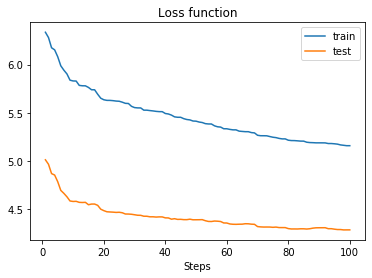

In [7]:
eval_result = model.train(
    surv_train,
    num_rounds=100,
    skip_rounds=10,
    evals=[(surv_train, 'train'), (surv_test, 'test')],
    plot=True
)

#### Prediction and Evaluation

Now we use the trained model to make prediction or evaluate model performance.

Give the prediction of EfnBoost model with:
- `model.predict`: Hazard Ratio of coxph
- `model.predict_survival_function`: survival function transformed from hazard ratio

Prediction of hazard ratio: [ 0.03163308 11.009921    0.43812597  0.34624097  6.503192  ]


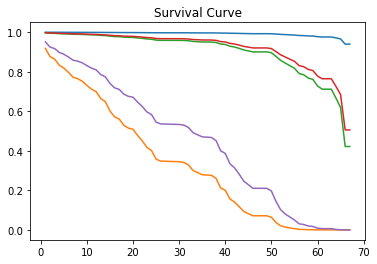

In [8]:
# select the first 5 samples
surv_data_now = surv_test.slice([i for i in range(5)])

# Predict Hazard Ratio
print("Prediction of hazard ratio:", model.predict(surv_data_now, output_margin=False))

# Predict Survival Function
result_survf = model.predict_survival_function(surv_data_now, plot=True)

In [9]:
result_survf

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0
0,0.999754,0.999620,0.999580,0.999475,0.999424,0.999347,0.999258,0.999230,0.999180,0.999099,...,0.981132,0.980491,0.977367,0.975760,0.975760,0.975760,0.971172,0.965962,9.395981e-01,9.395981e-01
1,0.917858,0.876024,0.863845,0.833002,0.818433,0.796679,0.772204,0.764771,0.751703,0.730617,...,0.001320,0.001052,0.000346,0.000195,0.000195,0.000195,0.000038,0.000006,3.823631e-10,3.823631e-10
2,0.996595,0.994747,0.994193,0.992755,0.992058,0.990996,0.989766,0.989385,0.988707,0.987588,...,0.768105,0.761183,0.728272,0.711861,0.711861,0.711861,0.666882,0.619000,4.219310e-01,4.219310e-01
3,0.997308,0.995846,0.995408,0.994270,0.993719,0.992877,0.991903,0.991602,0.991064,0.990178,...,0.811803,0.806016,0.778348,0.764454,0.764454,0.764454,0.726022,0.684507,5.056347e-01,5.056347e-01
4,0.950633,0.924796,0.917180,0.897694,0.888387,0.874363,0.858395,0.853505,0.844860,0.830780,...,0.019919,0.017415,0.009036,0.006443,0.006443,0.006443,0.002445,0.000809,2.737686e-06,2.737686e-06


In [10]:
# evaluate model performance 
print("td-CI on training set:", model.evals(surv_train))
print("td-CI on test set:", model.evals(surv_test))

td-CI on training set: 0.9254563688932987
td-CI on test set: 0.8532518254372559


#### save model

In [11]:
model.save_model("EfnBoost.model")